In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
from matplotlib.colors import LogNorm
import cPickle as pickle

In [2]:
import pyathena.yt_analysis.plot_projection as pproj
reload(pproj)

C:\anaconda2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'pyathena.yt_analysis.plot_projection' from 'pyathena\yt_analysis\plot_projection.pyc'>

In [3]:
from pyathena.yt_analysis.plot_projection import *

In [8]:
base='D:/yeongu/'
problem_id='RPS_8pc_ICM2'

for itime in range(250,260):
    surfname='{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    scalname='{}{}/surf/{}.{:04d}.scal4.p'.format(base,problem_id,problem_id,itime)
    starname='{}{}/starpar/{}.{:04d}.starpar.vtk'.format(base,problem_id,problem_id,itime)


    fig=pproj.plot_projection_icm(surfname,scalname,starname,stars=True,writefile=True,runaway=False)

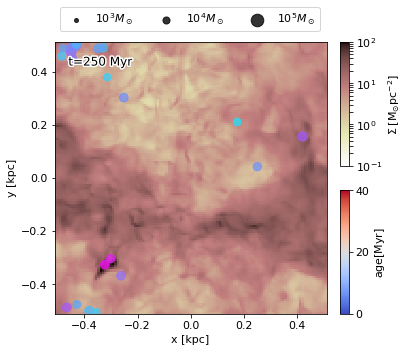

In [67]:
base='D:/yeongu/'
problem_id='RPS_8pc_ICM2'

for itime in range(250,257):
    surfname='{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime)
    starname='{}{}/starpar/{}.{:04d}.starpar.vtk'.format(base,problem_id,problem_id,itime)

    fig=pproj.plot_projection(surfname,starname,stars=True,writefile=False,runaway=False)

In [78]:
import glob
import os
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm,NoNorm,Normalize
import numpy as np

import pyathena.yt_analysis.ytathena as ya
from pyathena import read_starvtk,texteffect,set_units
from pyathena.yt_analysis.scatter_sp import scatter_sp

def plot_projection_all(surfnames,axis='y',pngfname=None,runaway=True,icm_max=1.0,iscal=-1,norm_factor=1.0,old=False):

    plt.rc('font',size=30)
    plt.rc('xtick',labelsize=30)
    plt.rc('ytick',labelsize=30)

    nsurf=len(surfnames)
    setup=True
    for i,surfname in enumerate(surfnames):
        #print surfnames
        aux=ya.set_aux(os.path.basename(surfname))
        scalfnames=glob.glob(surfname.replace('surf.p','scal?.p'))
        scalfnames.sort()
        starfnames=glob.glob(surfname.replace('surf/','starpar/').replace('surf.p','starpar.vtk'))+glob.glob(surfname.replace('surf/','id0/').replace('surf.p','starpar.vtk'))
        nstar=len(starfnames)
        nscal=len(scalfnames)
       
        if nstar > 0:
            starfname=starfnames[0]
            sp=read_starvtk(starfname)
        
        frb=pickle.load(open(surfname,'rb'))
        if nscal > 0:
            icm=pickle.load(open(scalfnames[iscal],'rb'))
            if icm[axis]['data'].max() > (icm_max*1.1):
                print scalfnames[iscal],icm[axis]['data'].min(),icm[axis]['data'].max()

        if 'time' in frb:
            tMyr=frb['time']
        else:
            time,sp=read_starvtk(starfname,time_out=True)
            tMyr=time*Myr
 
        if setup:
            ccc = -1.504
            extent=np.array(frb[axis]['bounds'])/1.e3
            x0=extent[0]
            y0=extent[2]
            Lx=extent[1]-extent[0]
            Lz=extent[3]-extent[2]
  
            if axis == 'z': 
                ix=6
                iz=ix*Lz/Lx
            else: 
                ix=3
                iz=ix*(Lz+ccc-0.45)/Lx
                #iz=ix*Lz/Lx # for normal height plot

            cism=plt.cm.bone_r #bone_r
            cicm=plt.cm.Reds #plt.cm.Reds
            cicm._init()
            x=np.arange(cicm.N)
            alphas=0.4*(np.tanh((x-100)/50.)+1)
            #alphas = np.linspace(0.5, 0.5, cicm.N)
            cicm._lut[:-3,-1] = alphas
            cicm._lut[-3,-1] = alphas.min()
            cicm._lut[-2,-1] = alphas.max()
  
            clim=aux['surface_density']['clim']
            
            cmin=clim[0]
            cmax=clim[1]
            print cmin, cmax
            if axis!='z': clim=(cmin*0.01,cmax)
            clim_icm=(0.0,0.5)
            norm_icm=Normalize()

            fig=plt.figure(0,figsize=(ix*nsurf+0.5,iz),frameon=False)
            if axis!='z':
                width_list=[1]*nsurf+[0.2]
            else:
                width_list=[1]*nsurf+[0.08]
            gs = gridspec.GridSpec(3,nsurf+1,width_ratios=width_list,wspace=0.0)
            setup=False
        #print width_list
        #print frb[axis]['data']
        #print frb[axis]['data'][200::,:].shape
        #print frb[axis]['data'].max()
        #print frb[axis]['data'].max(),frb[axis]['data'].min()
        #print frb[axis]['data'].shape
        #print np.log10(np.sum(frb[axis]['data'])*64/1024*8*896)
        if axis!='z':
            frb = frb[axis]['data']/0.027676/2 # for 4pc data
            #frb = frb[axis]['data']#/0.027676/2 # for 8pc data
        else:
            frb = frb[axis]['data']
        #frb = frb[axis]['data'] * 0.03526822*1024 # for 4pc x,y
        print frb.max(),frb.min()
        ax1=plt.subplot(gs[:,i])
        im1=ax1.imshow(frb,norm=LogNorm(),origin='lower')
        im1.set_extent(extent)
        im1.set_cmap(cism)
        im1.set_clim(clim)

        if nscal > 0:
            icm[axis]['data'] /= icm_max
            im11=ax1.imshow(icm[axis]['data'],norm=norm_icm,origin='lower')
            im11.set_extent(extent)
            im11.set_cmap(cicm) #iccm
            im11.set_clim(clim_icm)

        if nstar > 0: 
            scatter_sp(sp,ax1,axis=axis,runaway=runaway,type='surf',norm_factor=norm_factor,old='False')
        if axis!='z':
            if i==0:
                ax1.set_title('t=%3dMyr' % tMyr,**(texteffect(30)))
            else:
                ax1.set_title('%3dMyr' % tMyr,**(texteffect(30)))

    axes=fig.axes[:nsurf]
    ax1=axes[-1]
    cax=plt.subplot(gs[0,nsurf])
    cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
    cbar.set_label(aux['surface_density']['label'])
    
    if nscal > 0:
        cax=plt.subplot(gs[1,nsurf])
        cbar = fig.colorbar(im11,cax=cax,orientation='vertical')
        cbar.set_label(r'$C_{\rm ICM}$')

    if nstar > 0:
        cax=plt.subplot(gs[2,nsurf])
        cbar = colorbar.ColorbarBase(cax, ticks=[0,20,40],
             cmap=plt.cm.cool_r, norm=Normalize(vmin=0,vmax=40), 
             orientation='vertical')
        cbar.set_label(r'${\rm age [Myr]}$')

        s1=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e3)/norm_factor,color='k',
        alpha=.8,label=r'$10^3 M_\odot$')
        s2=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e4)/norm_factor,color='k',
        alpha=.8,label=r'$10^4 M_\odot$')
        s3=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e5)/norm_factor,
        color='k',alpha=.8,label=r'$10^5 M_\odot$')

        starlabels=(r'$10^3 M_\odot$',r'$10^4 M_\odot$',r'$10^5 M_\odot$') 
        if axis=='z':
            nsurf#legend=ax1.legend((s1,s2,s3),starlabels,loc='upper left',ncol=3,bbox_to_anchor=(0.0, 1.15),fontsize='medium',frameon=True)
        else:
            legend=ax1.legend((s1,s2,s3),starlabels,ncol=3,loc='lower right',fontsize='medium',frameon=True)

    if axis!='z':
        plt.setp(axes,'xlim',(x0,x0+Lx))
        plt.setp(axes,'ylim',(ccc,y0+Lz))
        #plt.setp(axes,'ylim',(y0,y0+Lz)) # for normal plot
    else:
        plt.setp(axes,'xlim',(x0,x0+Lx))
        plt.setp(axes,'ylim',(y0,y0+Lz))

    ax1=axes[0]
    if axis=='z':
        #plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
    elif axis=='y':
        #plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('z [kpc]')
    elif axis=='x':
        plt.setp(axes,'xlabel','y [kpc]')
        ax1.set_ylabel('y [kpc]')
        ax1.set_ylabel('z [kpc]')


    plt.setp([ax.get_yticklabels() for ax in axes[1:]],visible=False)
    plt.setp([ax.get_xticklabels() for ax in axes[1:]],visible=False)

    if pngfname is not None:
        plt.savefig(pngfname,bbox_inches='tight',dpi=200)
        plt.show()
        plt.close()
    else:
        return fig


In [5]:
aux=ya.set_aux()

In [6]:
aux['surface_density']

{'clim': (0.1, 100),
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x6c16b70>,
 'label': '$\\Sigma\\;[{\\rm M}_{\\odot} {\\rm pc}^{-2}]$',
 'log': True}

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
from matplotlib.colors import LogNorm
import cPickle as pickle
from pyathena.yt_analysis.scatter_sp import scatter_sp

In [11]:
import pyathena.yt_analysis.plot_projection as pproj
reload(pproj)

<module 'pyathena.yt_analysis.plot_projection' from 'pyathena\yt_analysis\plot_projection.pyc'>

In [12]:
from pyathena.yt_analysis.plot_projection import *

0.1 100
96.53853 1.1912024
320.1704 0.5602548
208.91162 0.087683216
172.10039 0.691353
165.08656 0.49161258
90.07963 0.6783078
171.44804 0.06871872
261.4225 0.08919121
189.47519 0.12632833
169.20885 0.27667356


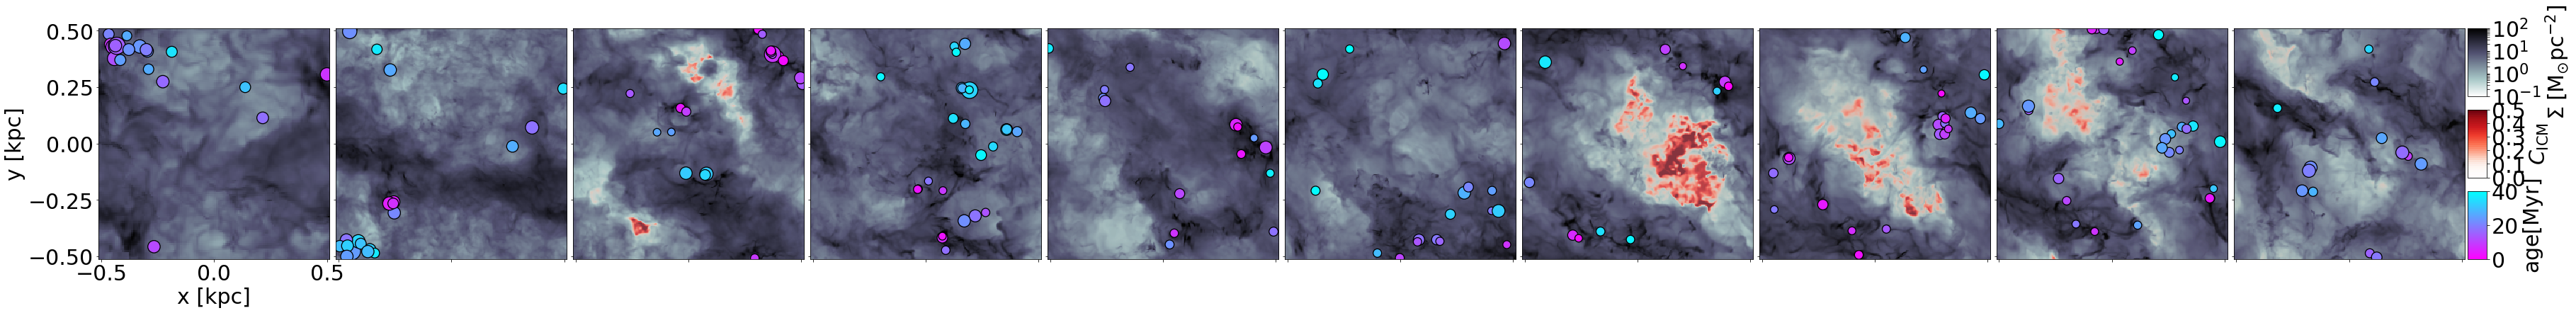

In [59]:
base='G:/yeongu/'
problem_id='RPS_4pc_ICM1_newacc'#'R8_8pc_metal'

surfnames=[]
for itime in (250, 260, 287, 312, 355, 377, 402, 420,432, 471):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='z',runaway=False,iscal=3,norm_factor=0.5,old='no',pngfname='surf_z_0812_%s' % problem_id)

0.1 100
124.61689802315097 0.002560179505672663
238.0414884052683 0.0030798278228858673
251.86143479715454 0.001676947462767176
66.88051767687129 0.0008432554232317358
109.80561228188235 0.0012849235761083777
145.50697274857347 0.0008968345081592496
80.52871274602786 0.0011487264923350662
123.40188590715111 0.001939241591826316
201.33442673143833 0.002215004541282733
102.81188525038931 7.671285805655056e-05


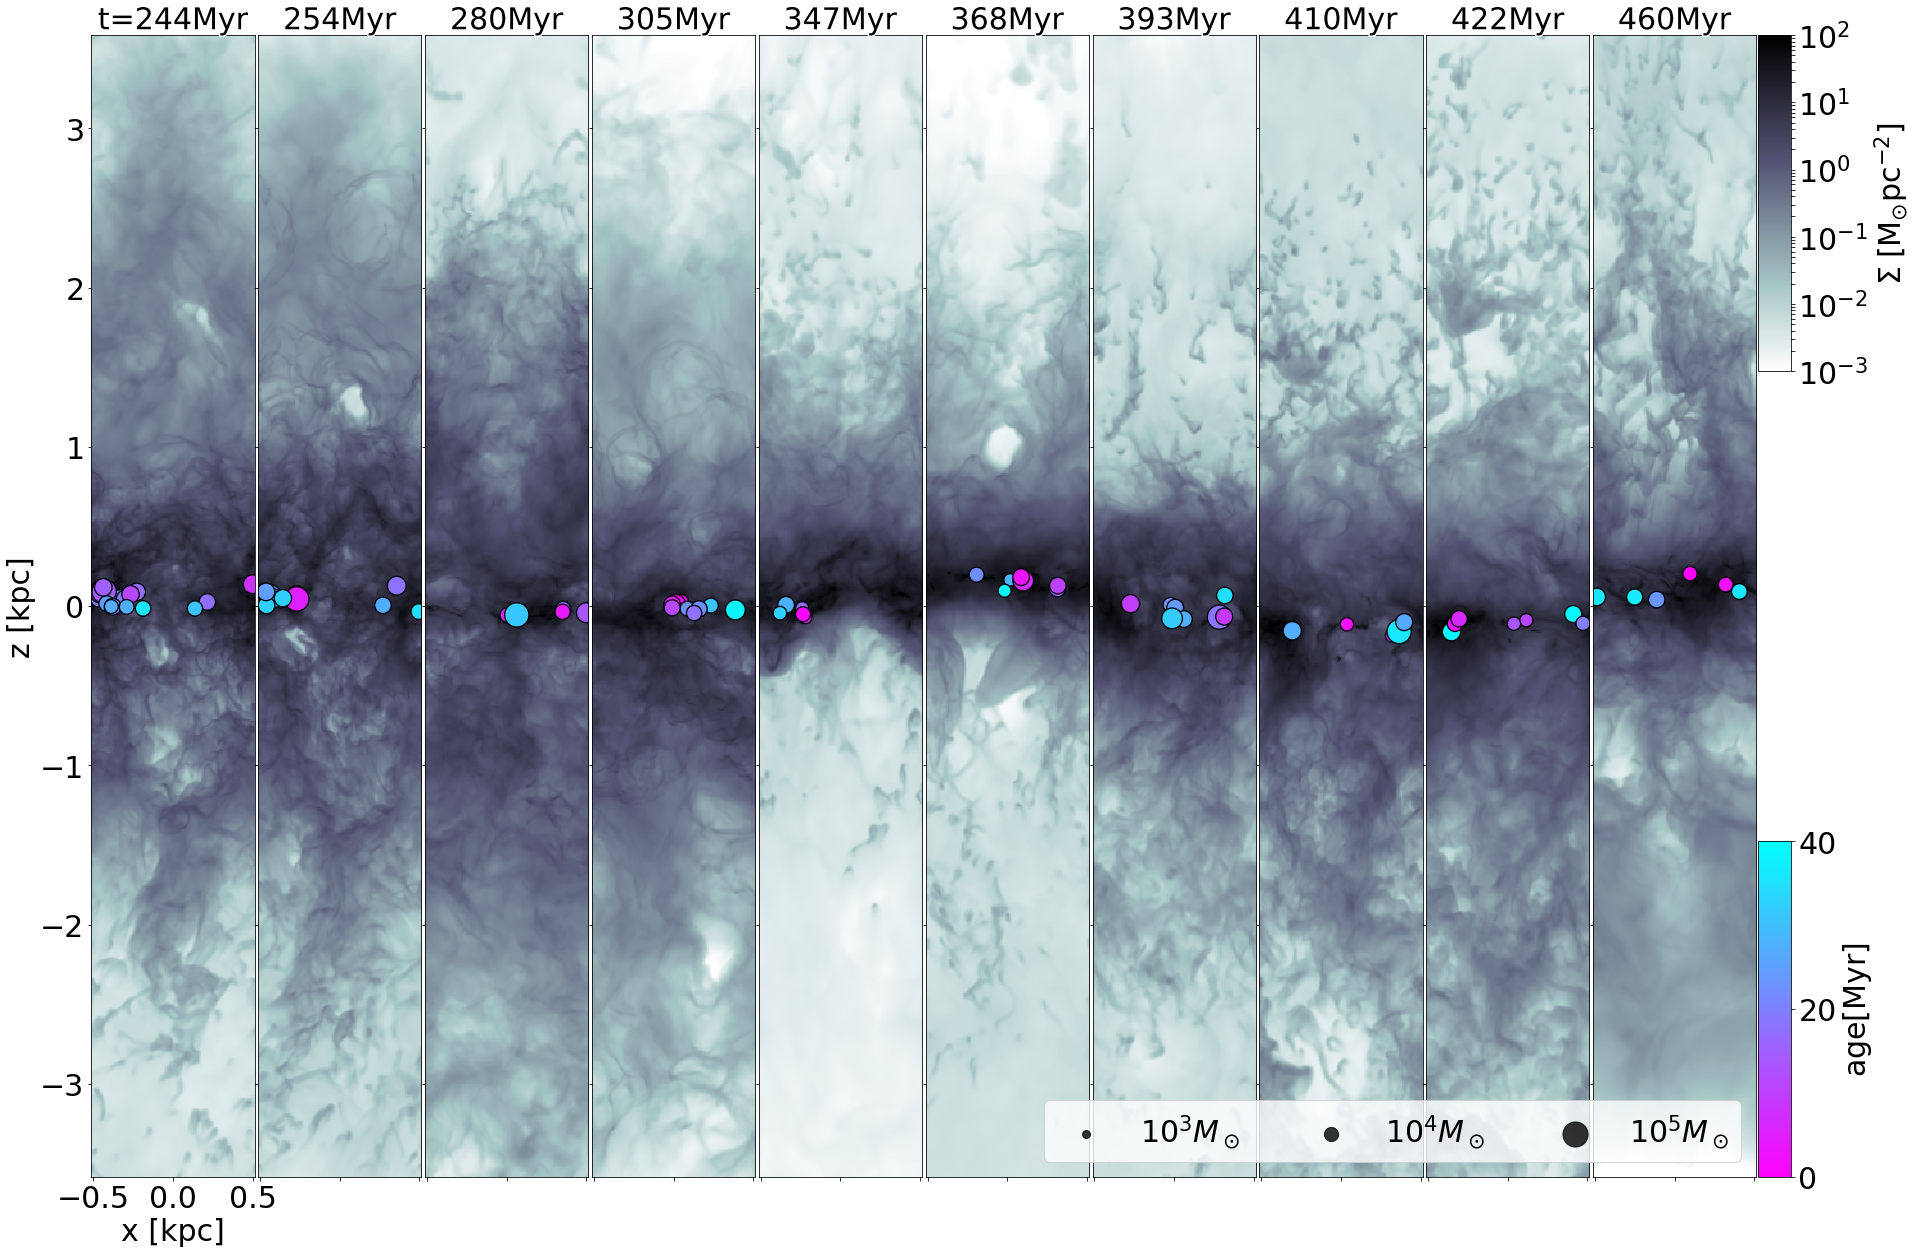

In [38]:
base='G:/yeongu/'
problem_id='RPS_8pc_noICM_newacc'

surfnames=[]
for itime in (250, 260, 287, 312, 355, 377, 402, 420,432, 471):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=3,norm_factor=0.5,old='no',pngfname='surf_0812_%s' % problem_id)

0.1 100
62.295677 0.0012798284
172.2621 0.0014099372
138.95152 0.0027144982
103.516525 0.0065683383
139.53792 0.0076113637
60.722744 0.007608573
35.225548 0.0036130329
21.806078 0.0036030766
24.55793 0.0036013888
56.42555 0.0035879582


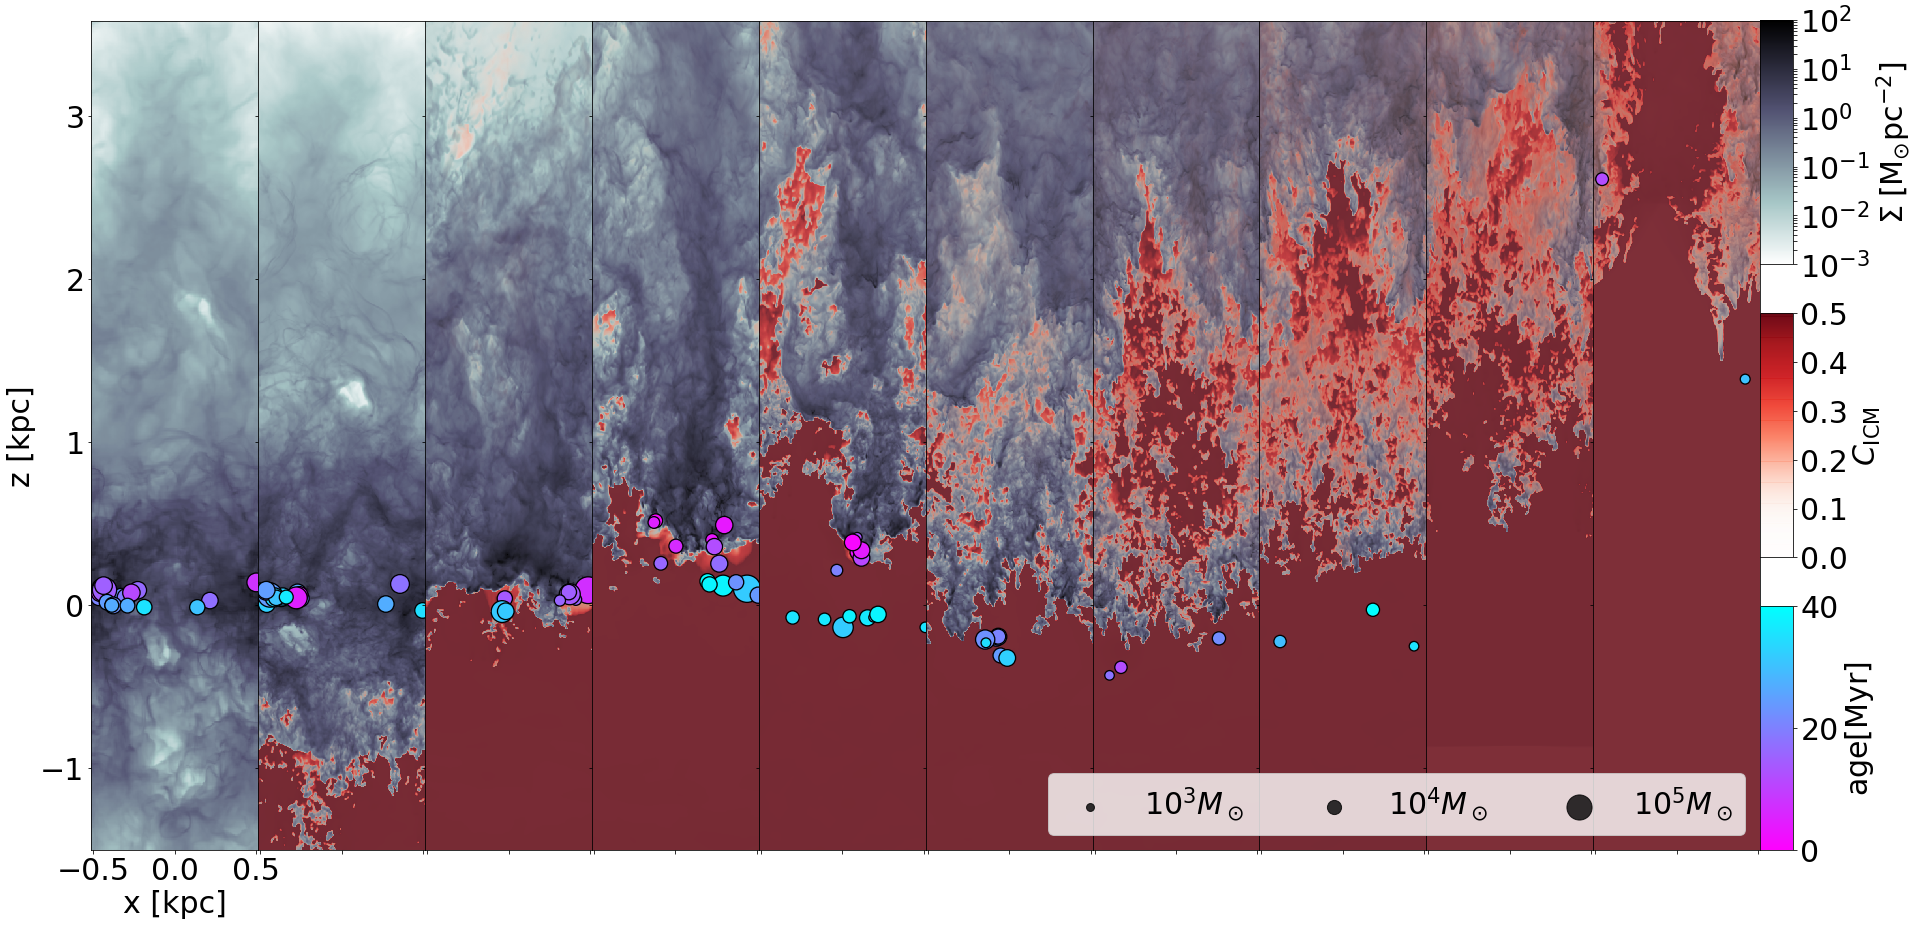

In [80]:
base='G:/yeongu/'
problem_id='RPS_4pc_ICM2_newacc'

surfnames=[]
for itime in (250, 260, 287, 312, 355, 377, 402, 420,432, 471):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=3,norm_factor=0.5,old='no',pngfname='surf_0812_%s' % problem_id)

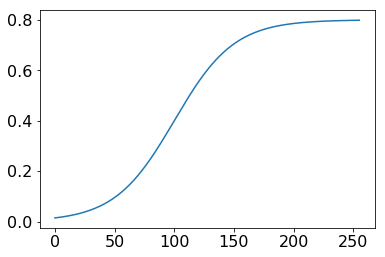

In [58]:
x=np.arange(256)
alphas=0.4*(np.tanh((x-100)/50.)+1)
plt.plot(alphas)

In [73]:
import glob
import os
import matplotlib.colorbar as colorbar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm,NoNorm,Normalize
import numpy as np

import pyathena.yt_analysis.ytathena as ya
from pyathena import read_starvtk,texteffect,set_units
from pyathena.yt_analysis.scatter_sp import scatter_sp

def plot_projection_all(surfnames,axis='y',pngfname=None,runaway=True,icm_max=1.0,iscal=-1,norm_factor=1.0,old=False):

    plt.rc('font',size=30)
    plt.rc('xtick',labelsize=30)
    plt.rc('ytick',labelsize=30)

    nsurf=len(surfnames)
    setup=True
    for i,surfname in enumerate(surfnames):
        #print surfnames
        aux=ya.set_aux(os.path.basename(surfname))
        scalfnames=glob.glob(surfname.replace('surf.p','scal?.p'))
        scalfnames.sort()
        starfnames=glob.glob(surfname.replace('surf/','starpar/').replace('surf.p','starpar.vtk'))+glob.glob(surfname.replace('surf/','id0/').replace('surf.p','starpar.vtk'))
        nstar=len(starfnames)
        nscal=len(scalfnames)
       
        if nstar > 0:
            starfname=starfnames[0]
            sp=read_starvtk(starfname)
        
        frb=pickle.load(open(surfname,'rb'))
        if nscal > 0:
            icm=pickle.load(open(scalfnames[iscal],'rb'))
            if icm[axis]['data'].max() > (icm_max*1.1):
                print scalfnames[iscal],icm[axis]['data'].min(),icm[axis]['data'].max()

        if 'time' in frb:
            tMyr=frb['time']
        else:
            time,sp=read_starvtk(starfname,time_out=True)
            tMyr=time*Myr
 
        if setup:
            ccc = -1.504
            extent=np.array(frb[axis]['bounds'])/1.e3
            x0=extent[0]
            y0=extent[2]
            Lx=extent[1]-extent[0]
            Lz=extent[3]-extent[2]
  
            if axis == 'z': 
                ix=6
                iz=ix*Lz/Lx
            else: 
                ix=3
                iz=ix*(Lz+ccc-0.45)/Lx
                #iz=ix*Lz/Lx # for normal height plot

            cism=plt.cm.bone_r #bone_r
            cicm=plt.cm.Reds #plt.cm.Reds
            cicm._init()
            x=np.arange(cicm.N)
            alphas=0.4*(np.tanh((x-100)/50.)+1)
            #alphas = np.linspace(0.5, 0.5, cicm.N)
            cicm._lut[:-3,-1] = alphas
            cicm._lut[-3,-1] = alphas.min()
            cicm._lut[-2,-1] = alphas.max()
  
            clim=aux['surface_density']['clim']
            
            cmin=clim[0]
            cmax=clim[1]
            print cmin, cmax
            if axis!='z': clim=(cmin*0.01,cmax)
            clim_icm=(0.0,0.5)
            norm_icm=Normalize()

            fig=plt.figure(0,figsize=(ix*nsurf+0.5,iz+ix),frameon=False)
            if axis!='z':
                width_list=[1]*nsurf+[0.2]
            else:
                width_list=[1]*nsurf+[0.08]
            gs = gridspec.GridSpec(4,nsurf+1,width_ratios=width_list,wspace=0.0)
            setup=False
        #print width_list
        #print frb[axis]['data']
        #print frb[axis]['data'][200::,:].shape
        #print frb[axis]['data'].max()
        #print frb[axis]['data'].max(),frb[axis]['data'].min()
        #print frb[axis]['data'].shape
        #print np.log10(np.sum(frb[axis]['data'])*64/1024*8*896)
        if axis!='z':
            frb2 = frb[axis]['data']/0.027676/2 # for 4pc data
            #frb = frb[axis]['data']#/0.027676/2 # for 8pc data
        #else:
        #    frb = frb[axis]['data']
        #frb = frb[axis]['data'] * 0.03526822*1024 # for 4pc x,y
        #print frb.max(),frb.min()
        ax1=plt.subplot(gs[0:3,i])
        
        im1=ax1.imshow(frb2,norm=LogNorm(),origin='lower')
        im1.set_extent(extent)
        im1.set_cmap(cism)
        im1.set_clim(clim)
        
        ax2=plt.subplot(gs[3,i])
        im2=ax2.imshow(frb['z']['data'],norm=LogNorm(),origin='lower')
        im2.set_extent(np.array(frb['z']['bounds'])/1.e3)
        im2.set_cmap(cism)
        im2.set_clim(clim)

        if nscal > 0:
            icm[axis]['data'] /= icm_max
            im11=ax1.imshow(icm[axis]['data'],norm=norm_icm,origin='lower')
            im11.set_extent(extent)
            im11.set_cmap(cicm) #iccm
            im11.set_clim(clim_icm)

        if nstar > 0: 
            scatter_sp(sp,ax1,axis=axis,runaway=runaway,type='surf',norm_factor=norm_factor,old='False')
        if axis!='z':
            if i==0:
                ax1.set_title('t=%3dMyr' % tMyr,**(texteffect(30)))
            else:
                ax1.set_title('%3dMyr' % tMyr,**(texteffect(30)))

    axes=fig.axes[:nsurf]
    ax1=axes[-1]
    cax=plt.subplot(gs[0,nsurf])
    cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
    cbar.set_label(aux['surface_density']['label'])
    
    if nscal > 0:
        cax=plt.subplot(gs[1,nsurf])
        cbar = fig.colorbar(im11,cax=cax,orientation='vertical')
        cbar.set_label(r'$C_{\rm ICM}$')

    if nstar > 0:
        cax=plt.subplot(gs[2,nsurf])
        cbar = colorbar.ColorbarBase(cax, ticks=[0,20,40],
             cmap=plt.cm.cool_r, norm=Normalize(vmin=0,vmax=40), 
             orientation='vertical')
        cbar.set_label(r'${\rm age [Myr]}$')

        s1=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e3)/norm_factor,color='k',
        alpha=.8,label=r'$10^3 M_\odot$')
        s2=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e4)/norm_factor,color='k',
        alpha=.8,label=r'$10^4 M_\odot$')
        s3=ax1.scatter(Lx*2,Lz*2,
        s=np.sqrt(1.e5)/norm_factor,
        color='k',alpha=.8,label=r'$10^5 M_\odot$')

        starlabels=(r'$10^3 M_\odot$',r'$10^4 M_\odot$',r'$10^5 M_\odot$') 
        if axis=='z':
            nsurf#legend=ax1.legend((s1,s2,s3),starlabels,loc='upper left',ncol=3,bbox_to_anchor=(0.0, 1.15),fontsize='medium',frameon=True)
        else:
            legend=ax1.legend((s1,s2,s3),starlabels,ncol=3,loc='lower right',fontsize='medium',frameon=True)

    if axis!='z':
        plt.setp(axes,'xlim',(x0,x0+Lx))
        plt.setp(axes,'ylim',(ccc,y0+Lz))
        #plt.setp(axes,'ylim',(y0,y0+Lz)) # for normal plot
    else:
        plt.setp(axes,'xlim',(x0,x0+Lx))
        plt.setp(axes,'ylim',(y0,y0+Lz))

    ax1=axes[0]
    if axis=='z':
        #plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
    elif axis=='y':
        #plt.setp(axes,'xlabel','x [kpc]')
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('z [kpc]')
    elif axis=='x':
        plt.setp(axes,'xlabel','y [kpc]')
        ax1.set_ylabel('y [kpc]')
        ax1.set_ylabel('z [kpc]')


    plt.setp([ax.get_yticklabels() for ax in axes[1:]],visible=False)
    plt.setp([ax.get_xticklabels() for ax in axes[1:]],visible=False)

    if pngfname is not None:
        plt.savefig(pngfname,bbox_inches='tight',dpi=200)
        plt.show()
        plt.close()
    else:
        return fig


0.1 100


TypeError: list indices must be integers, not tuple

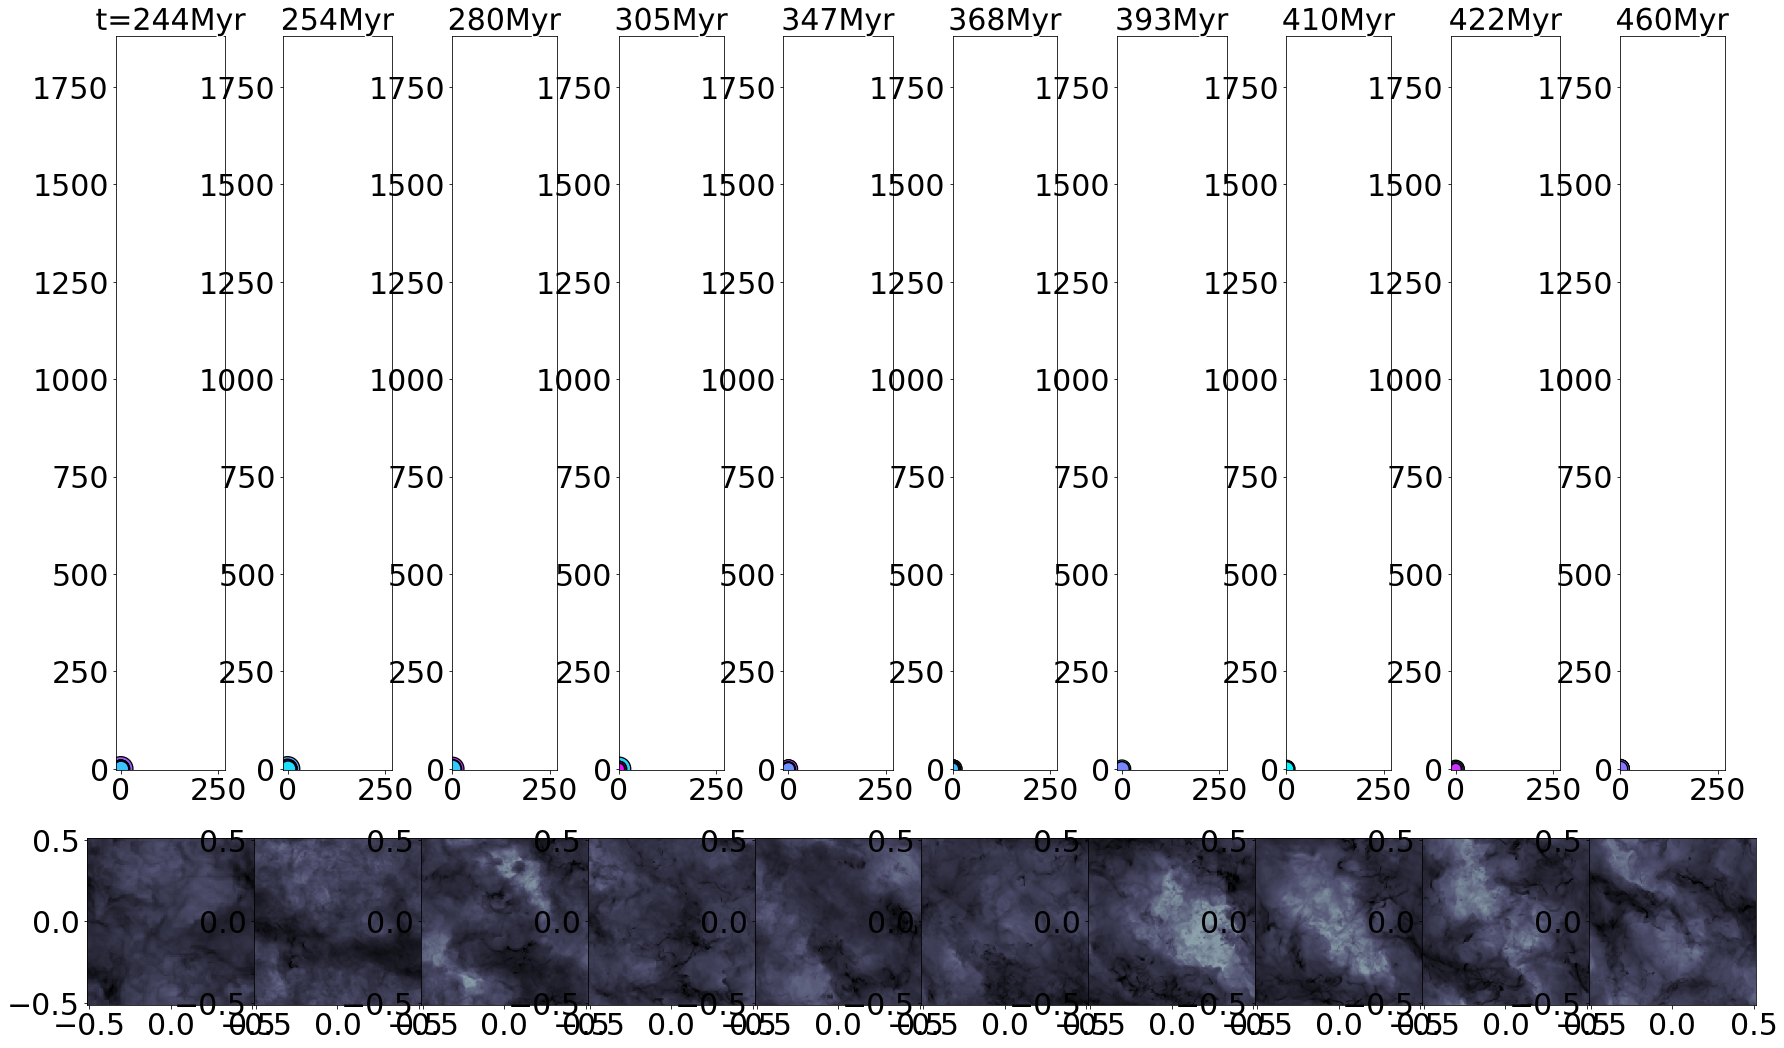

In [75]:
base='G:/yeongu/'
problem_id='RPS_4pc_ICM1_newacc'

surfnames=[]
for itime in (250, 260, 287, 312, 355, 377, 402, 420,432, 471):
    surfnames.append('{}{}/surf/{}.{:04d}.surf.p'.format(base,problem_id,problem_id,itime))

fig=plot_projection_all(surfnames,axis='y',runaway=False,iscal=3,norm_factor=0.5,old='no')#,pngfname='surf_0812_no_%s' % problem_id)